### CIFAR 100. Diseño de redes neuronales y LBG.

Cuaderno para trabajar en Google Colab, donde aprovechamos la potencia de cálculo de la GPU.

Se ha realizado con Colab Pro, con máquina de Altas Capacidades Ram y GPU.

Con el enlace, permite el acceso como lector:
https://colab.research.google.com/drive/1tBeIAsGz3UM74Xa6Lu1hf-M9-H4ibVpe?usp=sharing

In [ ]:
# Revisamos la memoria disponible en gpu.
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Nov 19 09:40:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Enunciado.

Práctica 1: CIFAR 100

Intentar conseguir el mejor score (fine tuning) con el dataset CIFAR 100 (se puede utilizar arquitecturas no secuenciales).

Hacer distintas predicciones con la red y plotear los resultados.

Comparar, con la función show_history, el performance de varias (<10) NN's con distintas neuronas y capas. Obtener las siguientes gráficas (longitud <20):

* score vs Batch_size (con la arquitectura conseguida previamente)
* score vs nº neuronas (con las capas de la arquitectura conseguida previamente)

Hacer la comparativa de scores (acc, recall, precision, f1, confusion matrix) entre los siguientes modelos:

- Random Forest
- Otro modelo a elegir de Machine Learning
- Una red neuronal
- Random forest sobre el histograma del LBP (extra)
- Una red neuronal sobre el histograma del LBP (extra)
LBP: https://www.pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from keras import layers, Input, regularizers
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD,Adam
from keras.metrics import AUC
from keras.losses import SparseCategoricalCrossentropy, MSE, MAE
from keras.layers import Conv2D,Dense,Flatten,Dropout,BatchNormalization,MaxPool2D
from keras.callbacks import Callback, EarlyStopping
import keras.backend as K

import tensorflow as tf

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn

from skimage.color import rgb2gray
from skimage.feature import local_binary_pattern
from skimage import feature
from scipy import stats




In [ ]:
# Intentamos mantener la memoria gpu controlada, los modelos de tensorflow ocupan mas memoria de la necesaria.
#https://medium.com/ibm-data-ai/memory-hygiene-with-tensorflow-during-model-training-and-deployment-for-inference-45cf49a15688
memoria_gpu=15109

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_virtual_device_configuration(gpu,
          [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=round(memoria_gpu,-3)/1000*1024)])

In [ ]:
# Funcion de graficos de history.
def show_history(history, metrics=['accuracy']):
  """
  Visualize history
  :param history:
  :return:
  """
  # Plot history: Loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Loss history')
  plt.ylabel('Loss value')
  plt.xlabel('No. epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  for metric in metrics:
    # Plot history:
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric])
    plt.title(metric + ' history')
    plt.ylabel(metric + ' value (%)')
    plt.xlabel('No. epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [ ]:
from keras.datasets import cifar100

# Para equiquetas Superclases, load_data('coarse')
(X_train, y_train), (X_validation, y_validation) = cifar100.load_data()
X_train = X_train/255
X_validation = X_validation/255

In [ ]:
           
fine_label_names=['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed',
                      'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy',
                      'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle',
                      'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
                      'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup',
                      'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest',
                      'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
                      'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard',
                      'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
                      'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid',
                      'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
                      'plain', 'plate', 'poppy', 'porcupine', 'possum',
                      'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
                      'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper',
                      'snail', 'snake', 'spider', 'squirrel', 'streetcar',
                      'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone',
                      'television', 'tiger', 'tractor', 'train', 'trout',
                      'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',
                      'wolf', 'woman', 'worm']

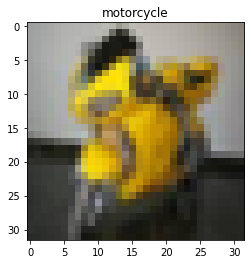

In [ ]:

plt.title(fine_label_names[int(y_train[152])])
plt.imshow(X_train[152])
plt.show()

1) Notas comunes a las arquitecturas:
- Para previnir overfitting, introducimos en los modelos:
    * Dropouts: Apagados aleatorios de neuronas.

- Para no continuar con entrenamieto improductivos, se ha dieñado un único callback que interrumpe el entreanmiento sí val_loos no mejora en 5 épocas.
- No me he limitado a redes densas, he implementado redes convolucionales y utilizado data augmentation.


Modelo_1: Red densa con dos capas ocultas ( 1024, 256):
Se para entre época 18 y 28, alcazando una precisión en validación de un 0.21. Mejoramos al azar ( 1/100 probabilidad para cada clase), pero el resultado es pobre.

In [ ]:
input = Input(shape=(32,32,3))
input_flat = layers.Flatten()(input)
layer = layers.Dense(units=1024, activation='relu')(input_flat)

layer = layers.Dense(units=256, activation='relu')(layer)
 
output = layers.Dense(units=100, activation='softmax')(layer)

# creamos el modelo
model_1 = Model(inputs=input, outputs=output)
print(model_1.summary())

# optimizador
optimizer = Adam(learning_rate=0.001)

# función loss
loss = SparseCategoricalCrossentropy(from_logits=False)

# Paramos el entrenamientocuando val_loss deje de mejorar para evitar overfitting
early_stop = EarlyStopping(monitor='val_loss',  mode='min', verbose=1, patience=5)

# métrica
metrics = ['accuracy']

# compilamos el modelo
model_1.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model_1._name='model_1'
history_1 = model_1.fit(x=X_train, y=y_train, batch_size=64, epochs=40,callbacks=early_stop,
                    validation_data=(X_validation, y_validation))



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 1024)              3146752   
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dense_2 (Dense)             (None, 100)               25700     
                                                                 
Total params: 3,434,852
Trainable params: 3,434,852
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/40
782/782 [==========================

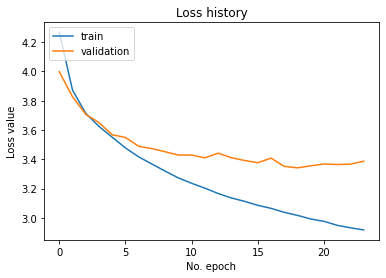

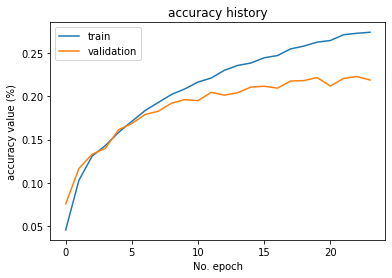

In [ ]:
show_history(history_1)

In [ ]:
def data_model(model_hist,model):
  y_pred=np.argmax(model.predict(X_validation),axis=1)
  print(classification_report( y_validation, y_pred))


  array=confusion_matrix( y_validation, y_pred)

  df_cm = pd.DataFrame(array, range(100), range(100))
  plt.figure(figsize=(15,8))
  sn.set(font_scale=0.8) # for label size
  sn.heatmap(df_cm, annot=False, annot_kws={"size": 8},fmt='g',cmap= 'viridis') # font size

  plt.show()
  
  return None
  


313/313 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

           0       0.39      0.42      0.40       100
           1       0.30      0.35      0.32       100
           2       0.16      0.25      0.19       100
           3       0.06      0.03      0.04       100
           4       0.11      0.14      0.12       100
           5       0.15      0.27      0.19       100
           6       0.14      0.23      0.17       100
           7       0.35      0.18      0.24       100
           8       0.20      0.06      0.09       100
           9       0.24      0.30      0.27       100
          10       0.09      0.06      0.07       100
          11       0.16      0.06      0.09       100
          12       0.18      0.23      0.20       100
          13       0.28      0.18      0.22       100
          14       0.12      0.15      0.14       100
          15       0.10      0.06      0.08       100
          16       0.35   

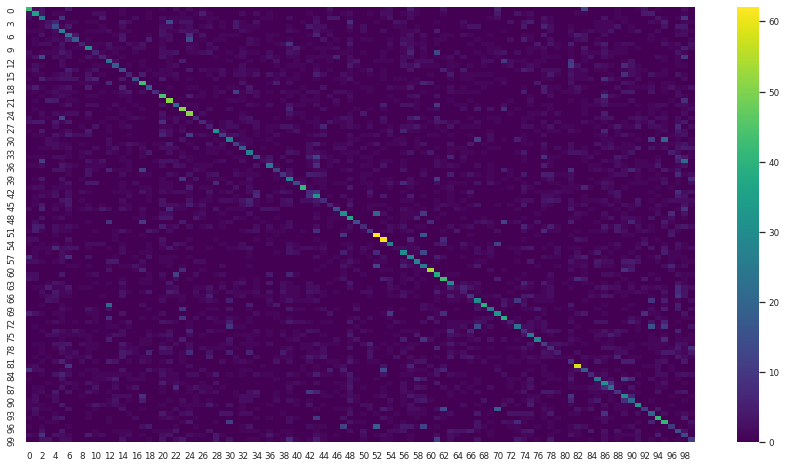

In [ ]:
data_model(history_1,model_1)

Modelo 2:
Introducimos una capa mas, y dropouts, y la entrenamos. Igualamos el resultado en términos de val_acc y mantenemos controlado el overfitting.

In [ ]:
#capas de la red 1024,512, 256
input = Input(shape=(32,32,3))
input_flat = layers.Flatten()(input)
layer = layers.Dense(units=1024, activation='relu')(input_flat)
layer = layers.Dropout(0.10)(layer)

layer = layers.Dense(units=512, activation='relu')(layer)
layer = layers.Dropout(0.10)(layer) 

layer = layers.Dense(units=256, activation='relu')(layer)
layer = layers.Dropout(0.10)(layer)
 
output = layers.Dense(units=100, activation='softmax')(layer)

# creamos el modelo
model_2 = Model(inputs=input, outputs=output)
print(model_2.summary())

# optimizador
optimizer = Adam(learning_rate=0.001)

# Paramos el entrenamientocuando val_loss deje de mejorar para evitar overfitting
early_stop = EarlyStopping(monitor='val_loss',  mode='min', verbose=1, patience=5)

# función loss
loss = SparseCategoricalCrossentropy(from_logits=False)

# métrica
metrics = ['accuracy']

# compilamos el modelo
model_2.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model_2._name='model_2'

history_2 = model_2.fit(x=X_train, y=y_train, batch_size=64, epochs=40,callbacks=early_stop,
                    validation_data=(X_validation, y_validation))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_3 (Dense)             (None, 1024)              3146752   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               1313

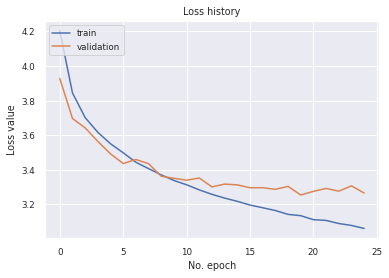

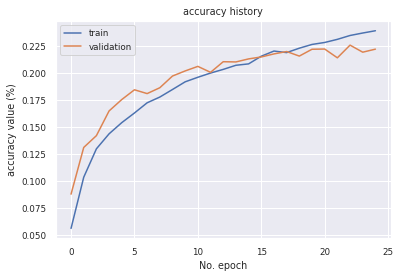

In [ ]:
show_history(history_2)

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.44      0.44      0.44       100
           1       0.25      0.34      0.29       100
           2       0.13      0.12      0.13       100
           3       0.06      0.08      0.07       100
           4       0.09      0.15      0.11       100
           5       0.25      0.24      0.24       100
           6       0.12      0.16      0.14       100
           7       0.21      0.35      0.26       100
           8       0.14      0.23      0.17       100
           9       0.29      0.31      0.30       100
          10       0.10      0.03      0.05       100
          11       0.28      0.15      0.19       100
          12       0.28      0.15      0.19       100
          13       0.18      0.15      0.16       100
          14       0.15      0.17      0.16       100
          15       0.16      0.14      0.15       100
          16       0.26   

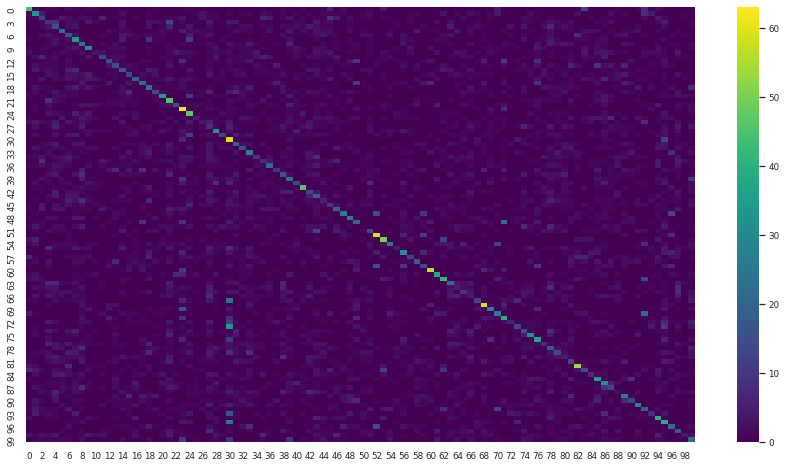

In [ ]:
data_model(history_2,model_2)

<Figure size 432x288 with 0 Axes>

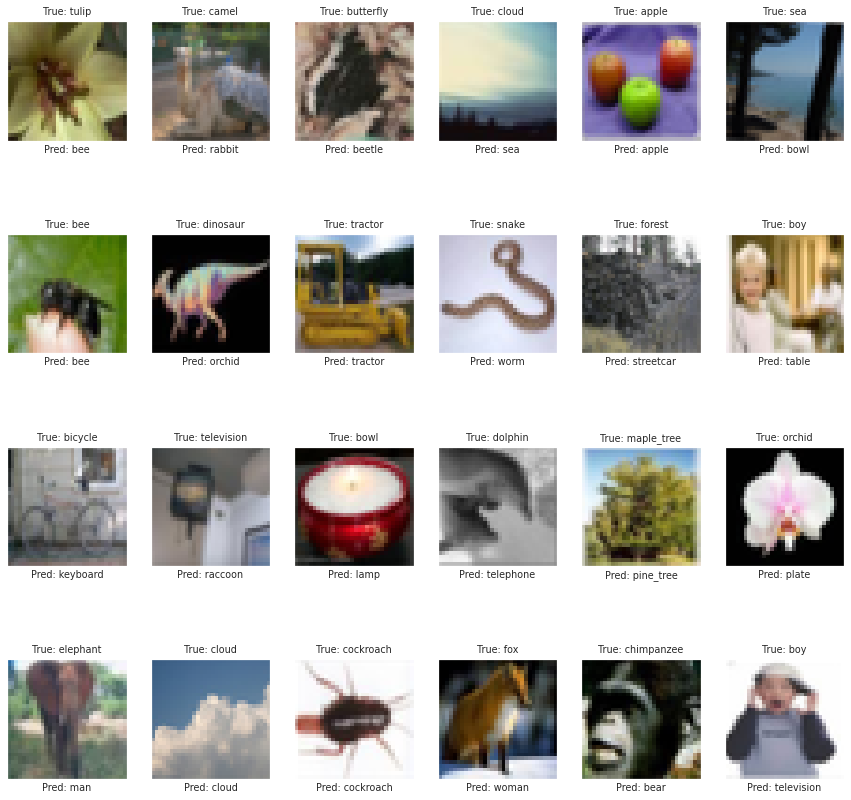

In [ ]:
#input images
plt.figure(1)
figs, axes = plt.subplots(4, 6,figsize=(15, 15))

for i in range(4):
  for j in range(6): 
    img_num=i*78+j+5
    y_pred=int(np.argmax(model_1.predict(X_validation[img_num],verbose=0),axis=1))
    true_label=int(y_validation[img_num])
    
    axes[i, j].imshow(X_validation[img_num,:,:,:])
    axes[i, j].set_xticks([])
    axes[i, j].set_yticks([])
    axes[i, j].title.set_text('True: '+fine_label_names[true_label])
    axes[i, j].set(xlabel=('Pred: '+fine_label_names[y_pred]))    



Modelo 3: 
Introducimos una capa oculta mas, mantenemos dropouts.
No conseguimos mejorar los resultados del modelo 2. Parece que seguir introduciendo capas densas, no es la solución. En alguna ocasión la red no se para en la mejora en las 40 épocas. 

In [ ]:

input = Input(shape=(32,32,3))
input_flat = layers.Flatten()(input)
layer = layers.Dense(units=1024, activation='relu')(input_flat)
layer = layers.Dropout(0.15)(layer) 

layer = layers.Dense(units=512, activation='relu')(layer)
layer = layers.Dropout(0.15)(layer) 

layer = layers.Dense(units=256, activation='relu')(layer)
layer = layers.Dropout(0.15)(layer) 

layer = layers.Dense(units= 128, activation='relu')(layer)
layer = layers.Dropout(0.15)(layer) 

output = layers.Dense(units=100, activation='softmax')(layer)

# creamos el modelo
model_3 = Model(inputs=input, outputs=output)
print(model_3.summary())

# optimizador
optimizer = Adam(learning_rate=0.001)

# Paramos el entrenamientocuando val_loss deje de mejorar para evitar overfitting
early_stop = EarlyStopping(monitor='val_loss',  mode='min', verbose=1, patience=5)


# función loss
loss = SparseCategoricalCrossentropy(from_logits=False)

# métrica
metrics = ['accuracy']
model_3._name='model_3'
# compilamos el modelo
model_3.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history_3 = model_3.fit(x=X_train, y=y_train, batch_size=64, epochs=70,callbacks=early_stop,
                    validation_data=(X_validation, y_validation))



Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 flatten_2 (Flatten)         (None, 3072)              0         
                                                                 
 dense_7 (Dense)             (None, 1024)              3146752   
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               524800    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 256)               1313

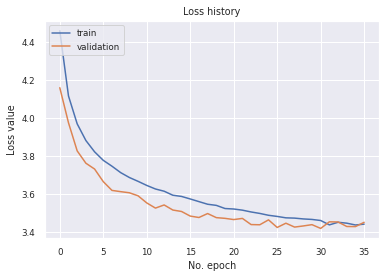

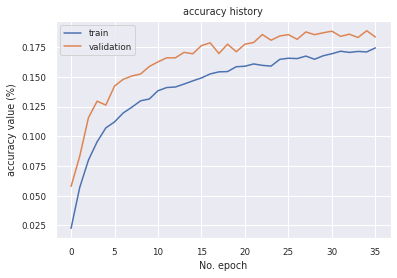

In [ ]:
show_history(history_3)

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.37      0.55      0.45       100
           1       0.32      0.30      0.31       100
           2       0.11      0.07      0.09       100
           3       0.17      0.10      0.13       100
           4       0.08      0.07      0.08       100
           5       0.12      0.27      0.17       100
           6       0.31      0.09      0.14       100
           7       0.23      0.14      0.17       100
           8       0.09      0.27      0.14       100
           9       0.37      0.16      0.22       100
          10       0.18      0.02      0.04       100
          11       0.25      0.02      0.04       100
          12       0.11      0.08      0.09       100
          13       0.05      0.03      0.04       100
          14       0.21      0.07      0.10       100
          15       0.12      0.03      0.05       100
          16       0.47   

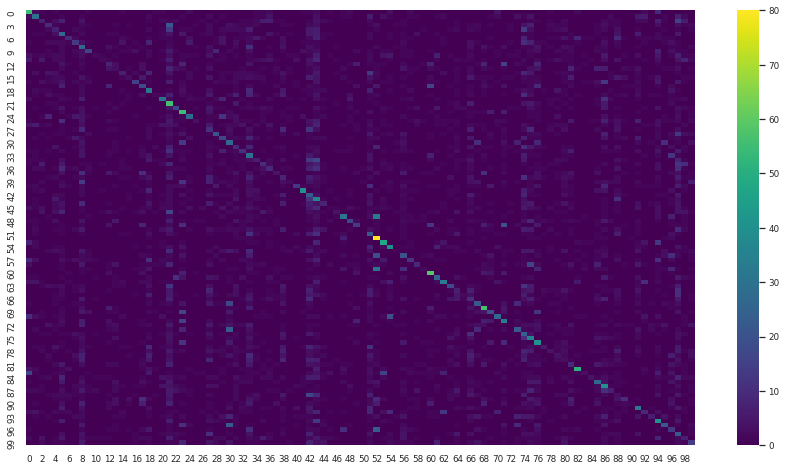

In [ ]:
data_model(history_3,model_3)

Modelo 4:
Combino los dos primeros modelos, en una red con dos entradas. ALcanza un 0.45 de accurancy, y la pédida en validación deja de mejorar alrededor de la etapa 30. Mucho overfitting con callbacks 0.25.

In [ ]:
def build_model_4():
  input = Input(shape=(32,32,3))
  input_flat = layers.Flatten()(input)

  layer_1_a = layers.Dense(units=1024, activation='relu')(input_flat)
  layer_2_a = layers.Dense(units=256, activation='relu')(layer_1_a)

  layer_1_b = layers.Dense(units=1024, activation='relu')(input_flat)
  layer_1_b = layers.Dropout(0.25)(layer_1_b)
  layer_2_b = layers.Dense(units=512, activation='relu')(layer_1_b)
  layer_2_b = layers.Dropout(0.25)(layer_2_b) 
  layer_3_b = layers.Dense(units=256, activation='relu')(layer_2_b)
  layer_3_b = layers.Dropout(0.15)(layer_3_b)

  layer_ab = tf.concat([layer_2_a, layer_3_b], axis=-1)


  output = layers.Dense(units=100, activation='softmax')(layer_ab)

  # creamos el modelo
  model_4 = Model(inputs=input, outputs=output)
  print(model_4.summary())

  # optimizador
  optimizer = Adam(learning_rate=0.0001)

  # Paramos el entrenamientocuando val_loss deje de mejorar para evitar overfitting
  early_stop = EarlyStopping(monitor='val_loss',  mode='min', verbose=1, patience=5)

  # función loss
  loss = SparseCategoricalCrossentropy(from_logits=False)

  # métrica
  metrics = ['accuracy']
  model_4._name='model_4'
  # compilamos el modelo
  model_4.compile(optimizer=optimizer, loss=loss, metrics=metrics)
  return model_4

model_4 = build_model_4()

history_4_64 = model_4.fit(x=X_train, y=y_train, batch_size=64, epochs=40, callbacks=early_stop,
                    validation_data=(X_validation, y_validation))


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 flatten_3 (Flatten)            (None, 3072)         0           ['input_4[0][0]']                
                                                                                                  
 dense_14 (Dense)               (None, 1024)         3146752     ['flatten_3[0][0]']              
                                                                                                  
 dropout_7 (Dropout)            (None, 1024)         0           ['dense_14[0][0]']               
                                                                                            

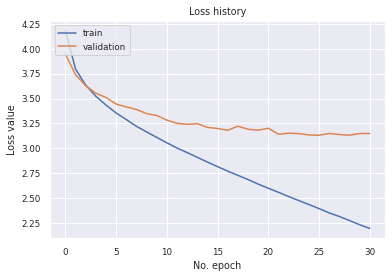

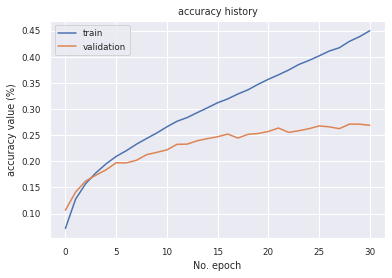

In [ ]:
show_history(history_4_64)

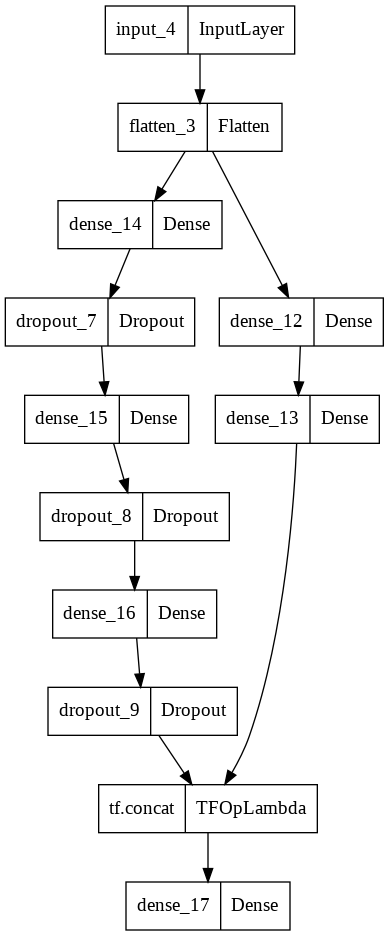

In [ ]:
from keras.utils import plot_model
plot_model(model_4)

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.51      0.49      0.50       100
           1       0.32      0.51      0.39       100
           2       0.20      0.14      0.16       100
           3       0.38      0.05      0.09       100
           4       0.11      0.20      0.14       100
           5       0.23      0.22      0.23       100
           6       0.22      0.21      0.22       100
           7       0.27      0.33      0.30       100
           8       0.16      0.30      0.21       100
           9       0.47      0.27      0.34       100
          10       0.18      0.11      0.14       100
          11       0.25      0.17      0.20       100
          12       0.35      0.18      0.24       100
          13       0.29      0.22      0.25       100
          14       0.28      0.19      0.23       100
          15       0.16      0.12      0.14       100
          16       0.52   

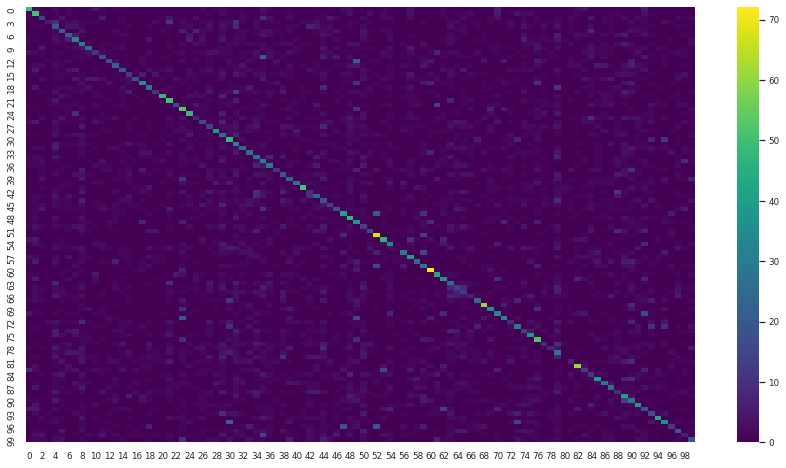

In [ ]:
data_model(history_4_64,model_4)

Vamos a revisar la influencia de los batch_size en el desempeño de las redes:

Ciclos de aprendizaje por epoca Tam_muestra/batch_size sobre batch_size.
- Tamaño pequeño: Mucho cliclos de entrenamiento de los pesos con pocos elementos en cada ciclo. Lentitud computacional por la complejidad del proceso.
- Tamaño Grande: Menos ciclos de aprendizaje en cada época con un número mayor de elementos en cada lote. Más rápido computacionalmente.

Ante una misma estructura, las redes se ajustan antes con lotes pequeño, tambien paralizan su aprendizaje en épocas mas tempranas. Lotes muy grandes parecen emperorar el rendimiento.

In [ ]:
model_4 = build_model_4()
history_4_32=model_4.fit(x=X_train, y=y_train, batch_size=32, epochs=40, callbacks=early_stop,
                    validation_data=(X_validation, y_validation))
model_4 = build_model_4()

history_4_128=model_4.fit(x=X_train, y=y_train, batch_size=128, epochs=40, callbacks=early_stop,
                    validation_data=(X_validation, y_validation))
model_4 = build_model_4()

history_4_256=model_4.fit(x=X_train, y=y_train, batch_size=256, epochs=40, callbacks=early_stop,
                    validation_data=(X_validation, y_validation)) 

model_4 = build_model_4()
history_4_512=model_4.fit(x=X_train, y=y_train, batch_size=512, epochs=40, callbacks=early_stop,
                    validation_data=(X_validation, y_validation))

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 flatten_4 (Flatten)            (None, 3072)         0           ['input_5[0][0]']                
                                                                                                  
 dense_20 (Dense)               (None, 1024)         3146752     ['flatten_4[0][0]']              
                                                                                                  
 dropout_10 (Dropout)           (None, 1024)         0           ['dense_20[0][0]']               
                                                                                            

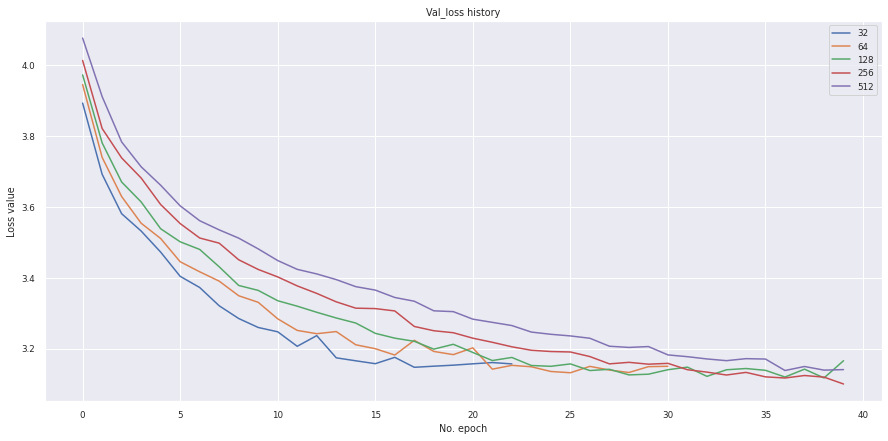

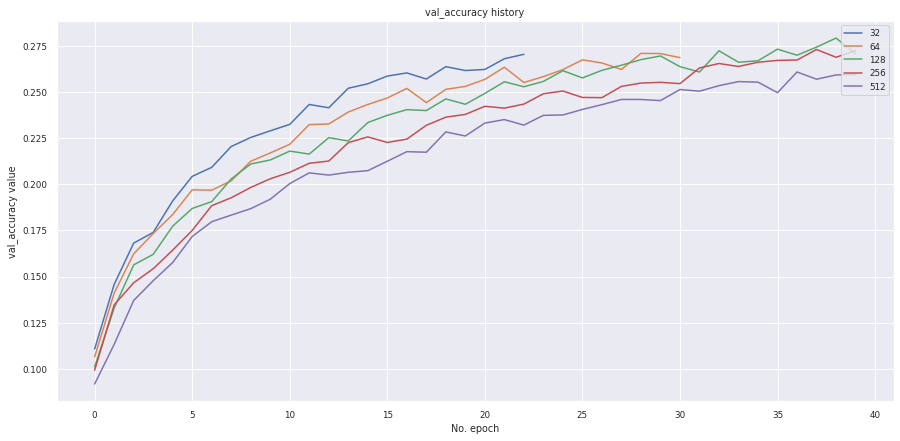

In [ ]:

plt.rcParams["figure.figsize"] = (15,7)
plt.plot(history_4_32.history['val_loss'])
plt.plot(history_4_64.history['val_loss'])
plt.plot(history_4_128.history['val_loss'])
plt.plot(history_4_256.history['val_loss'])
plt.plot(history_4_512.history['val_loss'])
plt.title('Val_loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(['32', '64','128','256','512'], loc='upper right')
plt.show()

print('')
plt.plot(history_4_32.history['val_accuracy'])
plt.plot(history_4_64.history['val_accuracy'])
plt.plot(history_4_128.history['val_accuracy'])
plt.plot(history_4_256.history['val_accuracy'])
plt.plot(history_4_512.history['val_accuracy'])
plt.title('val_accuracy history')
plt.ylabel('val_accuracy value')
plt.xlabel('No. epoch')
plt.legend(['32', '64','128','256','512'], loc='upper right')
plt.show()


plt.rcParams["figure.figsize"] = (8,4)

#### Redes Convuncionales.
Damos un salto de gigante en la sofisticación de la red, introduciendo capas convuncionales. Trasformamos la representación de nuestras imagenes para que la red sea capaz de aprender de un número mucho mas elevado de patrones de las imagenes.
En esta red con una sola capa convuncional, estamos pasando de un tensor (32,32,3) de las anteriores redes densas a un tensor (16,16,256).
256 representaciones de la mitad de tamaño que la imagen original ( en pixels). 
Eleva el accurancy en val al 0.58, la red multiplica su complejidad 20 veces para duplicar su eficacia. 
Tenemos mucho overfitting, a pesar de introducir dropotus de 0.5 despúes de cada capa.

In [ ]:
input = Input(shape=(32,32,3))
conv=Conv2D(32,(3,3),1,padding='same',activation='relu')(input)
#conv=BatchNormalization()(conv)
conv=MaxPool2D(pool_size=2, strides=2)(conv)

conv=Conv2D(64,(3,3),1,padding='same',activation='relu')(conv)
conv=MaxPool2D(pool_size=2, strides=2)(conv)


conv=Dropout(.30)(conv)
conv=BatchNormalization()(conv)


conv=Flatten()(conv)
conv=Dropout(.30)(conv)
layer=Dense(1000,activation='relu')(conv)

layer=Dropout(.3)(layer)
output=Dense(100,activation='softmax')(layer)


# creamos el modelo
model_5 = Model(inputs=input, outputs=output)
print(model_5.summary())

# optimizador
optimizer = Adam(learning_rate=0.0001)

# Paramos el entrenamientocuando val_loss deje de mejorar para evitar overfitting
early_stop = EarlyStopping(monitor='val_loss',  mode='min', verbose=1, patience=5)

# función loss
loss = SparseCategoricalCrossentropy(from_logits=False)



# métrica
metrics = ['accuracy']
model_5._name='model_5'
# compilamos el modelo
model_5.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history_5 = model_5.fit(x=X_train, y=y_train, batch_size=64, epochs=40, callbacks=early_stop,
                    validation_data=(X_validation, y_validation))


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 dropout_22 (Dropout)        (None, 8, 8, 64)          0   

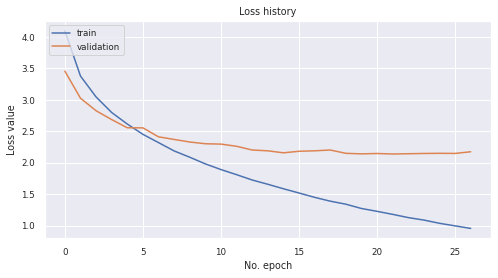

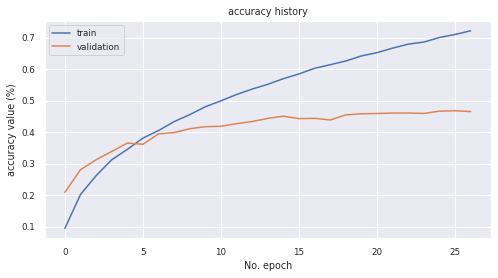

In [ ]:
show_history(history_5)

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.61      0.78      0.69       100
           1       0.55      0.63      0.59       100
           2       0.44      0.31      0.36       100
           3       0.31      0.27      0.29       100
           4       0.32      0.29      0.31       100
           5       0.42      0.44      0.43       100
           6       0.52      0.46      0.49       100
           7       0.46      0.46      0.46       100
           8       0.71      0.54      0.61       100
           9       0.60      0.68      0.64       100
          10       0.42      0.27      0.33       100
          11       0.40      0.31      0.35       100
          12       0.44      0.48      0.46       100
          13       0.36      0.31      0.33       100
          14       0.35      0.29      0.32       100
          15       0.30      0.36      0.33       100
          16       0.60   

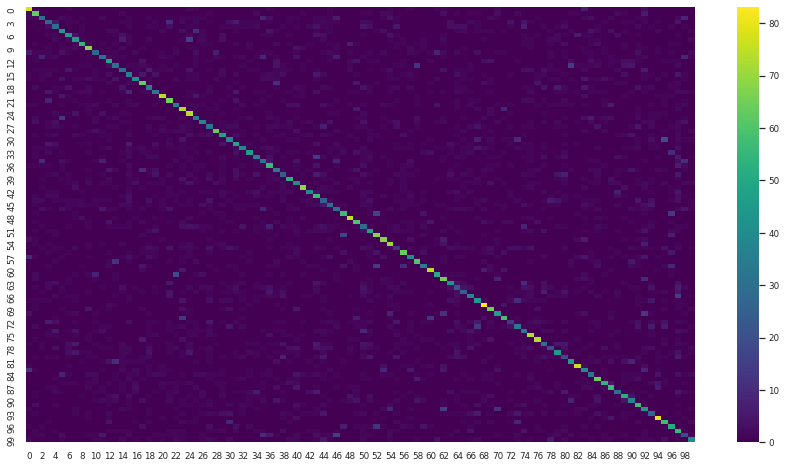

In [ ]:
data_model(history_5,model_5)

Vamos a darle mas potencia a nuestra red en forma de capar convuncionales, le daremos 512 representaciones de (4X4). Conseguimos llevar el acierto al 0.56.
Alcanzamos la cifra de 0.68 en val_acc, que hace que nuestro calsificador se pueda considerar aceptable-bueno. 
Tendríamos que buscar la manera de corregir el overfitting.

In [ ]:

input = Input(shape=(32,32,3))

# 1 ciclo
conv=Conv2D(128,(3,3),1,padding='same',activation='relu')(input)
conv=Conv2D(128,(3,3),1,padding='same',activation='relu')(conv)
conv=Dropout(.2)(conv)
conv=MaxPool2D(pool_size=2, strides=2)(conv)

# 2 ciclo
conv=Conv2D(256,(3,3),1,padding='same',activation='relu')(conv)
conv=Conv2D(256,(3,3),1,padding='same',activation='relu')(conv)
conv=MaxPool2D(pool_size=2, strides=2)(conv)
conv=Dropout(.3)(conv)

# 3 ciclo
conv=Conv2D(512,(3,3),1,padding='same',activation='relu')(conv)
conv=Conv2D(512,(3,3),1,padding='same',activation='relu')(conv)
conv=MaxPool2D(pool_size=2, strides=2)(conv)
conv=Dropout(.3)(conv)


conv=Flatten()(conv)

layer=Dense(1024,activation='relu')(conv)
layer=Dropout(.5)(layer)

layer=Dense(1024,activation='relu')(layer)
layer=Dropout(.5)(layer)

output=Dense(100,activation='softmax')(layer)


# creamos el modelo
model_6 = Model(inputs=input, outputs=output)
print(model_6.summary())

# optimizador
optimizer = Adam(learning_rate=0.0001)

# Paramos el entrenamientocuando val_loss deje de mejorar para evitar overfitting
early_stop = EarlyStopping(monitor='val_loss',  mode='min', verbose=1, patience=5)

# función loss
loss = SparseCategoricalCrossentropy(from_logits=False)


# métrica
metrics = ['accuracy']
model_6._name='model_6'
# compilamos el modelo
model_6.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history_6_64 = model_6.fit(x=X_train, y=y_train, batch_size=64, epochs=40, callbacks=early_stop,
                    validation_data=(X_validation, y_validation))


Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       3584      
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 dropout_25 (Dropout)        (None, 32, 32, 128)       0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 256)       295168    
                                                           

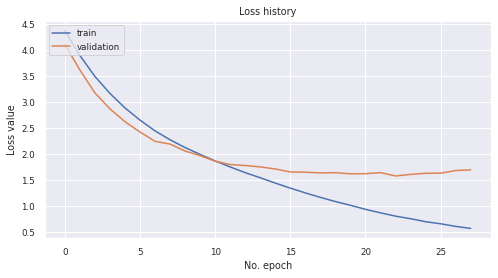

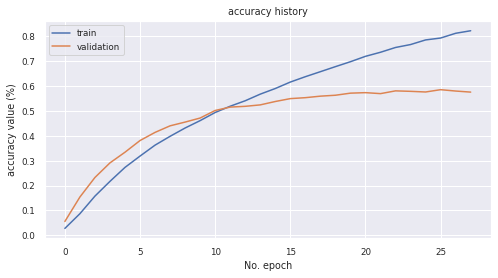

In [ ]:
show_history(history_6_64)

313/313 [==============================] - 2s 7ms/step
              precision    recall  f1-score   support

           0       0.77      0.80      0.78       100
           1       0.67      0.67      0.67       100
           2       0.40      0.50      0.45       100
           3       0.41      0.36      0.39       100
           4       0.34      0.48      0.40       100
           5       0.56      0.62      0.59       100
           6       0.57      0.76      0.65       100
           7       0.73      0.61      0.66       100
           8       0.88      0.65      0.75       100
           9       0.83      0.75      0.79       100
          10       0.47      0.38      0.42       100
          11       0.39      0.28      0.33       100
          12       0.66      0.58      0.62       100
          13       0.63      0.41      0.50       100
          14       0.50      0.43      0.46       100
          15       0.47      0.53      0.50       100
          16       0.68   

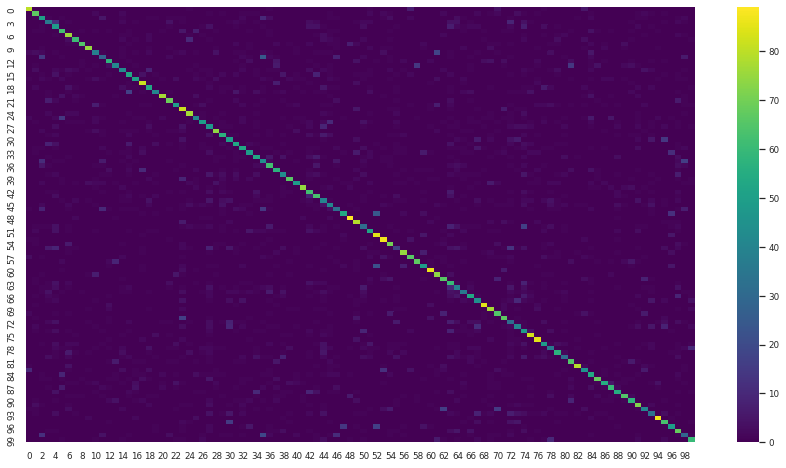

In [ ]:
data_model(history_6_64,model_6)

In [ ]:
def size(model): # Compute number of params in a model (the actual number of floats)
    return sum([np.prod(K.get_value(w).shape) for w in model.trainable_weights])

In [ ]:
modelos=[model_1,model_2,model_3,model_4,model_5,model_6]

for model in modelos:
  num_par= [size(x)/1000000 for x in modelos]
  
histories = [history_1,history_2, history_3, history_4_64, history_5, history_6_64]

for history in histories:
  acc_list=[x.history['val_accuracy'][-1] for x in histories]

tipo=['Rnn','Rnn','Rnn','Rnn','Cnn','Cnn']
colors=["#00FF00", "#00FF00","#00FF00","#00FF00", "#FF0066","#FF0066"]



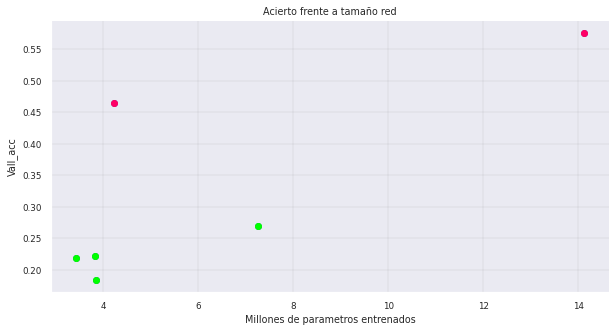

In [ ]:
import matplotlib.pyplot as plt
# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(num_par,acc_list)

#iterates through the dataset plotting each data point and assigning it its corresponding color and label
for i in range(len(colors)):
    ax.scatter(num_par[i], acc_list[i], color=colors[i])


#adds a title and axes labels
ax.set_title('Acierto frente a tamaño red')
ax.set_xlabel('Millones de parametros entrenados')
ax.set_ylabel('Vall_acc')

#removing top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#adds major gridlines
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

plt.show()

Los puntos rojos son las redes con nodos convuncionales, se observa su mejor rendimiento. Especialmtne rentable en términos de eficiencia de tamaño de red es el modelo 5.

### Clasificador randomforrest.

Entrenamos un clasificador randomforrest. Los resultados 

In [ ]:
X_train_gb=X_train.reshape((X_train.shape[0],-1))
X_test_gb=X_validation.reshape((X_validation.shape[0],-1))
y_train_gb= y_train.flatten()
y_test_gb = y_validation.flatten()


In [ ]:
model_rfc = RandomForestClassifier(n_estimators=100,
                             criterion='gini',
                            max_depth= 30,
                            max_features= 'auto',
                            min_samples_leaf=10)

model_rfc.fit(X_train_gb, y_train_gb)

# make predictions
expected_y  = y_test_gb
predicted_y = model_rfc.predict(X_test_gb)

metric_rfc=classification_report(expected_y, predicted_y,output_dict=True)
rfc_frame=pd.DataFrame.from_dict((metric_rfc['weighted avg']), orient='index').T
rfc_frame['val_accuracy']=metric_rfc['accuracy']
rfc_frame['nombre']='RFC'


### Modelo Naive Bayes.
Elegimos este modelo por su rápidez de entrenamiento. No esperamos grandes resultados.

In [ ]:
from sklearn.naive_bayes import GaussianNB

model_nb = GaussianNB()
model_nb.fit(X_train_gb, y_train_gb)

expected_y  = y_test_gb
predicted_y = model_nb.predict(X_test_gb)

metric_nb=classification_report(expected_y, predicted_y,output_dict=True)
nb_frame=pd.DataFrame.from_dict((metric_nb['weighted avg']), orient='index').T
nb_frame['val_accuracy']=metric_nb['accuracy']
nb_frame['nombre']='Naive Bayes'


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
expected_y  = y_validation
predicted_y = np.argmax(model_6.predict(X_validation),axis=1)
metric_6=classification_report(expected_y, predicted_y,output_dict=True)
mod_6_frame=pd.DataFrame.from_dict((metric_6['weighted avg']), orient='index').T
mod_6_frame['val_accuracy']=metric_6['accuracy']
mod_6_frame['nombre']='Convonuncional NN'

313/313 [==============================] - 2s 7ms/step


In [ ]:
expected_y  = y_validation
predicted_y = np.argmax(model_4.predict(X_validation),axis=1)
metric_4 = classification_report(expected_y, predicted_y,output_dict=True)
mod_4_frame=pd.DataFrame.from_dict((metric_4['weighted avg']), orient='index').T
mod_4_frame['val_accuracy']=metric_4['accuracy']
mod_4_frame['nombre']='NN'

313/313 [==============================] - 1s 2ms/step


In [ ]:
resultados=pd.concat([rfc_frame,nb_frame,mod_4_frame,mod_6_frame])

In [ ]:
resultados

,precision,recall,f1-score,support,val_accuracy,nombre
0,0.220907,0.2147,0.191512,10000.0,0.2147,RFC
0,0.121434,0.1128,0.086876,10000.0,0.1128,Naive Bayes
0,0.265200,0.2595,0.248162,10000.0,0.2595,NN
0,0.587231,0.5761,0.575068,10000.0,0.5761,Convonuncional NN


El modelo Naive Bayes no es capaz de dircernir mas que el azar. Los modelos Random Forrest y la NN ofrecen un rendimiento parecido. Las redes neuronales convoluncionales son el mejor modelo, casí con un rendimiento que dobla los demás modelos.
Sí le añadiesemos data augmentation o transfer learning conseguiríamos mejorar los resultados.

## Trabajo con histograma LBP.
Empezamos por diseñar una función que obtenga los histogramas de los lbp.
Pero los resultados obtenidos tanto para random forrest o NN son decepcionantes, no sé sí estaré haciendo mal el preocesado.

In [ ]:
def image_to_lbp_hist(image,num_points,radius,eps=1e-7):
  image_gray=rgb2gray(image*255)
  lbp = local_binary_pattern(image_gray, num_points, radius,method='uniform')
  (histogram,_) =np.histogram(lbp.ravel(),
                            bins=np.arange(0, num_points + 3),
                            range=(0, num_points + 2)
                            ) 
  histogram= histogram.astype("float")
  histogram /= (histogram.sum() + eps)
  return  histogram

In [ ]:
image_to_lbp_hist(X_train[145],24,3 )

array([0.05761719, 0.02734375, 0.03808594, 0.02636719, 0.03027344,
       0.02050781, 0.02246094, 0.02539062, 0.02832031, 0.03320312,
       0.03808594, 0.03613281, 0.04199219, 0.04394531, 0.0234375 ,
       0.0234375 , 0.00683594, 0.0078125 , 0.01367187, 0.01171875,
       0.02050781, 0.02246094, 0.0234375 , 0.015625  , 0.02246094,
       0.33886719])

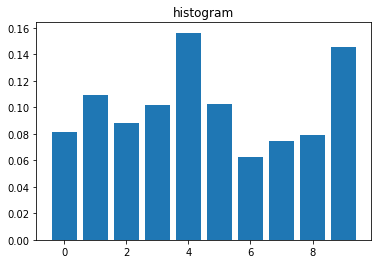

In [ ]:
plt.bar(x=range(len(image_to_lbp_hist(X_train[18],24,3))),height=image_to_lbp_hist(X_train[18],24,3)) 
plt.title("histogram") 
plt.show()


In [ ]:
# Transformamos train y validation.
X_train_lbp=[]
X_test_lbp=[]
for imagen in X_train:
  X_train_lbp.append(image_to_lbp_hist(imagen,24,3))
X_train_lbp=np.asarray(X_train_lbp)
for imagen in X_validation:
  X_test_lbp.append(image_to_lbp_hist(imagen,24,3))
X_test_lbp=np.asarray(X_test_lbp)

In [ ]:
X_train_lbp.shape

(50000, 26)

In [ ]:
# Aplanamos las etiquetas.
y_train_lbp= y_train.flatten()
y_test_lbp = y_validation.flatten()


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import pandas as pd
model_rfc = RandomForestClassifier(n_estimators=100,
                             criterion='gini',
                            max_depth= 24,
                            max_features= 'auto',
                            min_samples_leaf=10)

model_rfc.fit(X_train_lbp, y_train_lbp)

# make predictions
expected_y  = y_test_lbp
predicted_y = model_rfc.predict(X_test_lbp)

metric_rfc=metrics.classification_report(expected_y, predicted_y,output_dict=True)
rfc_frame=pd.DataFrame.from_dict((metric_rfc['weighted avg']), orient='index').T
rfc_frame['val_accuracy']=metric_rfc['accuracy']
rfc_frame['nombre']='RFC LBP'


In [ ]:
rfc_frame

,precision,recall,f1-score,support,val_accuracy,nombre
0,0.073408,0.0923,0.075499,10000.0,0.0923,RFC LBP


In [ ]:
resultados=pd.concat([resultados,rfc_frame])

In [ ]:
resultados

,precision,recall,f1-score,support,val_accuracy,nombre
0,0.220907,0.2147,0.191512,10000.0,0.2147,RFC
0,0.121434,0.1128,0.086876,10000.0,0.1128,Naive Bayes
0,0.265200,0.2595,0.248162,10000.0,0.2595,NN
0,0.587231,0.5761,0.575068,10000.0,0.5761,Convonuncional NN
0,0.055464,0.0765,0.053371,10000.0,0.0765,RFC LBP


In [ ]:

input = Input(shape=(26,))
input_flat = layers.Flatten()(input)

layer = layers.Dense(units=100, activation='relu')(input_flat)
#layer = layers.Dropout(0.25)(layer) 


layer = layers.Dense(units=100, activation='relu')(layer)
#layer = layers.Dropout(0.25)(layer)
layer = layers.Dense(units=50, activation='relu')(layer)

output = layers.Dense(units=100, activation='softmax')(layer)

# creamos el modelo
model_7 = Model(inputs=input, outputs=output)
print(model_7.summary())

# optimizador
optimizer = Adam(learning_rate=0.0001)

# función loss
loss = SparseCategoricalCrossentropy(from_logits=False)

# métrica
metrics = ['accuracy']
model_7._name='model_7'
# compilamos el modelo
model_7.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history_7 = model_7.fit(x=X_train_lbp, y=y_train_lbp, batch_size=64, epochs=20,
                    validation_data=(X_test_lbp, y_test_lbp))


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 26)]              0         
                                                                 
 flatten_1 (Flatten)         (None, 26)                0         
                                                                 
 dense_4 (Dense)             (None, 100)               2700      
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 50)                5050      
                                                                 
 dense_7 (Dense)             (None, 100)               5100      
                                                                 
Total params: 22,950
Trainable params: 22,950
Non-trainable

Intento trabajar con los propios patrones binarios en red neuronal, pero no mejora los resultados con RGB.